In [32]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, grad, jit, random

import matplotlib
import matplotlib.pyplot as plt

import zarr
import xarray as xr

from tqdm.notebook import tqdm
from tqdm.notebook import trange

In [33]:
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'
era5 = xr.open_zarr(obs_path)

In [34]:
# obs_path = 'gs://weatherbench2/datasets/era5_weekly/1959-2023_01_10-1h-240x121_equiangular_with_poles_conservative.zarr'
# era5 = xr.open_zarr(obs_path)

In [35]:
era5['temperature'].shape

(92044, 13, 64, 32)

In [36]:
# 23386 / 104
4 * 365

1460

In [37]:
ntrain = 4 * 365 * 10
nval = 4 * 365 * 5
ntest = 4 * 365 * 5

train = era5['temperature'][0:ntrain,-1]
val = era5['temperature'][ntrain:(ntrain+nval),-1]
test = era5['temperature'][(ntrain+nval):(ntrain+nval+ntest),-1]

In [38]:
t_train = era5['time'][0:ntrain]
t_val = era5['time'][ntrain:(ntrain+nval)]
t_test = era5['time'][(ntrain+nval):(ntrain+nval+ntest)]

dtrain = np.array(train)
dval = np.array(val)
dtest = np.array(test)

dtrain = dtrain - 273.15
dval = dval - 273.15
dtest = dtest - 273.15

KeyboardInterrupt: 

In [ ]:
dtrain = np.moveaxis(dtrain, 1, 2)
dtrain = np.rot90(dtrain, k = 2, axes = (1, 2))
dtrain = np.flip(dtrain, axis = 2)

dval = np.moveaxis(dval, 1, 2)
dval = np.rot90(dval, k = 2, axes = (1, 2))
dval = np.flip(dval, axis = 2)

dtest = np.moveaxis(dtest, 1, 2)
dtest = np.rot90(dtest, k = 2, axes = (1, 2))
dtest = np.flip(dtest, axis = 2)

In [ ]:
train_day = np.array(train['time']["time.dayofyear"])
val_day = np.array(val['time']["time.dayofyear"])
test_day = np.array(test['time']["time.dayofyear"])

# ## anomalize
# dmeans = [np.mean(dtrain[train_day == i]) for i in range(1, 367)]

# for i in trange(len(dtrain), leave = False):
#   dtrain[i] = dtrain[i] - dmeans[train_day[i]-1]

# for i in trange(len(dval), leave = False):
#   dval[i] = dval[i] - dmeans[val_day[i]-1]

# for i in trange(len(dtest), leave = False):
#   dtest[i] = dtest[i] - dmeans[test_day[i]-1]

In [12]:
# ## detrend
# t = np.linspace(0, 1, ntrain+nval+ntest)
# t1 = t[:ntrain]
# t2 = t[ntrain:(ntrain+nval)]
# t3 = t[(ntrain+nval):(ntrain+nval+ntest)]
# d = np.mean(dtrain, axis = (1, 2))

# beta = np.polyfit(t1, d, 1)
# dtrain = dtrain - np.polyval(beta, t[:ntrain])[:,None,None]
# dval = dval - np.polyval(beta, t2)[:,None,None]
# dtest = dtest - np.polyval(beta, t3)[:,None,None]

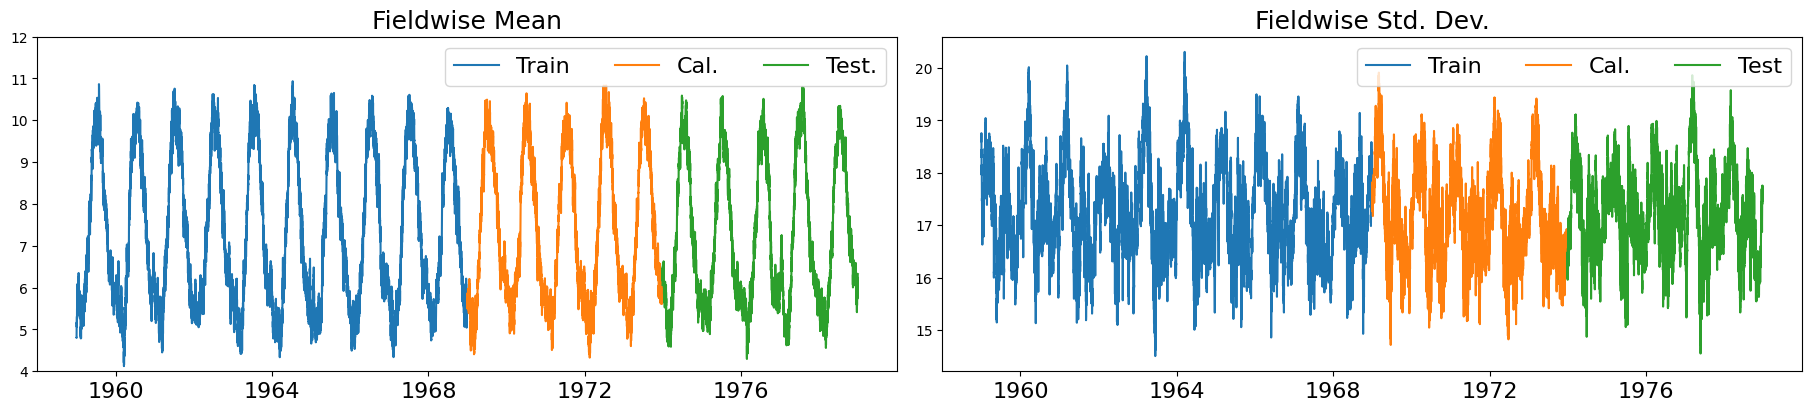

In [60]:
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (18, 4))

# ax[0,0].imshow(np.mean(dtrain[0:4], axis = 0), cmap = 'RdBu_r')
# ax[0,1].imshow(np.mean(dtrain[4:8], axis = 0), cmap = 'RdBu_r')
# ax[0,0].set_title('January 1st 1959')
# ax[0,1].set_title('January 2nd 1959')

ax[0].plot(t_train, np.mean(dtrain, axis = (1, 2)), label = 'Train')
ax[0].plot(t_val, np.mean(dval, axis = (1, 2)), label = 'Cal.')
ax[0].plot(t_test, np.mean(dtest, axis = (1, 2)), label = 'Test.')
ax[0].set_title('Fieldwise Mean', fontsize = 18)
ax[0].set_ylim(4, 12)
ax[0].legend(ncol = 3, fontsize = 16)
ax[0].xaxis.set_tick_params(labelsize=16)

ax[1].plot(t_train, np.std(dtrain, axis = (1, 2)), label = 'Train')
ax[1].plot(t_val, np.std(dval, axis = (1, 2)), label = 'Cal.')
ax[1].plot(t_test, np.std(dtest, axis = (1, 2)), label = 'Test')
ax[1].set_title('Fieldwise Std. Dev.', fontsize = 18)
ax[1].legend(ncol = 3, fontsize = 16)
ax[1].xaxis.set_tick_params(labelsize=16)

plt.show()

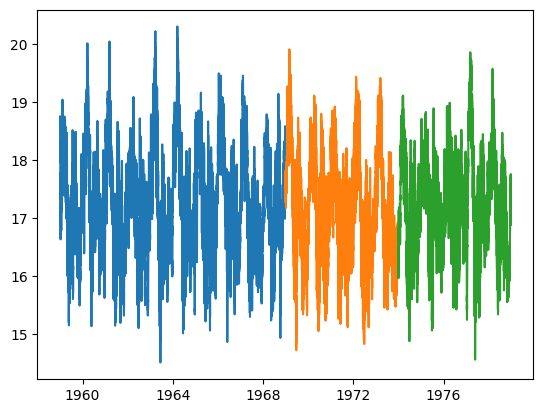

In [14]:
plt.plot(t_train, np.std(dtrain, axis = (1, 2)))
plt.plot(t_val, np.std(dval, axis = (1, 2)))
plt.plot(t_test, np.std(dtest, axis = (1, 2)))

In [15]:
np.save('../data/era5_train_small.npy', dtrain)
np.save('../data/era5_val_small.npy', dval)
np.save('../data/era5_test_small.npy', dtest)